# Function demonstrations using the `artools.py` package

## Python imports
We need to import the `artools.py` package before we can use the functions. If `artools.py` is stored under a different directory to the default Python path, then the location must be added to the system path using `sys.path.append()`.

In [1]:
# artools
import sys
sys.path.append('../../../artools/')
import artools
artools = reload(artools)

Other imports useful for this notebook

In [2]:
import scipy as sp
import scipy.integrate

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Vertex enumeration of a set of inequality constraints (hyperlane equations) using `con2vert()`

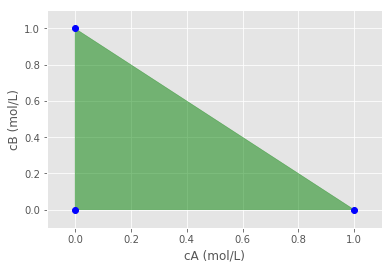

In [3]:
A = sp.array([[-1., 0], [0, -1.], [1., 1]])
b = sp.array([[0, 0, 1.]]).T

Xs = artools.con2vert(A, b)

fig = artools.plot_region2d(Xs, plot_verts=True)
ax = fig.gca()

ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.1, 1.1])
ax.set_xlabel("cA (mol/L)")
ax.set_ylabel("cB (mol/L)")

plt.show(fig)

## `con2vert()` and `vert2con()`: Vertex enumeration and facet enumeration

First define rate kinetics to use as a test set of data.

In [4]:
#2D van de Vusse kinetics
#A -> B -> C
#2A -> D

def rate_fn(C,t):
    cA = C[0]
    cB = C[1]
    
    #rate constants
    k1 = 1.0;
    k2 = 1.0;
    k3 = 10.0;

    #r = [rA, rB]
    return sp.array([-k1*cA - 2*k3*cA**2,
                    k1*cA - k2*cB])

Now find the region generated by a PFR trajectory from the feed

'\nfig = artools.plot_region2d(Xs, color=[0.5, 0.3, 0.2], alpha=0.35)\nax = fig.gca()\n\n#plot PFR trajectory for comparison\nax.plot(pfr_cs[:, 0], pfr_cs[:, 1], "r-")\n\nax.set_xlim([-0.1, 1.1])\nax.set_ylim([-0.01, 0.1])\n\nax.set_xlabel(\'cA (mol/L)\')\nax.set_ylabel(\'cB (mol/L)\')\n\nplt.show(fig)\n'

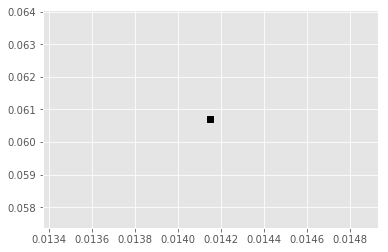

In [6]:
#Feed point
Cf = sp.array([1., 0])

#integrate PFR
pfr_ts = sp.logspace(-3, sp.log10(10), 100)
pfr_cs = scipy.integrate.odeint(rate_fn, Cf, pfr_ts)

#find hyperplane inequality equations using vert2con() (facet enumeration)
A, b = artools.vert2con(pfr_cs)

#find vertices of hyperplane constraints using con2vert() (vertex enumeration)
Xs = artools.con2vert(A, b)

#plot the region
fig = artools.plot_region2d(Xs, color=[0.5, 0.3, 0.2], alpha=0.35)
ax = fig.gca()

#plot PFR trajectory for comparison
ax.plot(pfr_cs[:, 0], pfr_cs[:, 1], "r-")

ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.01, 0.1])

ax.set_xlabel('cA (mol/L)')
ax.set_ylabel('cB (mol/L)')

plt.show(fig)

## `inregion()` and `outregion()`: determine if points lie in/out of a region

In [ ]:
#Generate a large list of random points and test to see if they lie in out the polytop defined by A*x <= b
Cs = sp.rand(int(1e5),2)

ks = []
for i, ci in enumerate(Cs):
    if artools.outRegion(ci, A, b):
        ks.append(i)
        
#plot points
fig = plt.figure()
ax = fig.gca()
ax.plot(Cs[ks, 0], Cs[ks, 1], "rx")

ax.set_ylim([0, 0.1])
ax.set_xlabel('cA (mol/L)')
ax.set_ylabel('cB (mol/L)')

plt.show()

We can do the same to find points inside the region using inregion()

In [ ]:
ks = []
for i, ci in enumerate(Cs):
    if artools.inRegion(ci, A, b):
        ks.append(i)
        
#plot points
fig = plt.figure()
ax = fig.gca()
ax.plot(Cs[ks, 0], Cs[ks, 1], "bx")

ax.set_ylim([0, 0.1])
ax.set_xlabel('cA (mol/L)')
ax.set_ylabel('cB (mol/L)')

plt.show()

## `ptsInRegion()` and `ptsOutRegion()`: find points in/out of a polytope when working with an array of points

In [ ]:
#system of inequalities
A = sp.array([[-1., 0.],
              [0., -1.],
              [1., 1.],
              [0., 1.]])

b = sp.array([0., 0., 1., 0.5]).T

#A set of random points
Xs = artools.rand_pts(1e4, sp.array([-0.1, 1.1, -0.1, 1.1]))

Cs_in, ks_in = artools.ptsInRegion(Xs, A,b)
Cs_out, ks_out = artools.ptsOutRegion(Xs, A,b)

#plot points in different colors
fig = plt.figure()
ax = fig.gca()

ax.plot(Cs_in[:, 0], Cs_in[:, 1], "bx")
ax.plot(Cs_out[:, 0], Cs_out[:, 1], "rx")

ax.set_xlabel("x")
ax.set_xlabel("y")

plt.show(fig)

## `allcomb()`: Cartesian product of a list of lists (useful for generating n-dimensional grids) 

Generate a grid of points based in separate axis spacings using `scipy.linspace()` to control the number of points along each axis.

In [ ]:
x_range = sp.linspace(0, 1, 5)
y_range = sp.linspace(0, 1, 10)

Xs = artools.allcomb(x_range, y_range)
Xs

Plot the points

In [ ]:
fig = plt.figure()
ax = fig.gca()

plt.plot(Xs[:, 0], Xs[:, 1], "bo")

ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.1, 1.1])
ax.set_xlabel("x")
ax.set_ylabel("y")

plt.show()

## `calc_CSTR_locus()`: CSTR locus solver using Monte Carlo geometric method 

This method uses a brute-force determination of the colinearity between r(C) and (C - Cf). It is not very fast, but it is robust and easy to use.

In [ ]:
num_pts = 300
axis_lims = sp.array([0., 1., 0., 0.12])

cstr_cs, cstr_ts = artools.calc_cstr_locus(Cf, rate_fn, num_pts, axis_lims, tol=1e-7)

plt.figure()

plt.plot(Cf[0], Cf[1], "g^")
plt.plot(cstr_cs[:, 0], cstr_cs[:, 1], "bx")
plt.plot(pfr_cs[:, 0], pfr_cs[:, 1], "r-")

plt.axis(axis_lims)
plt.xlabel("cA (mol/L)")
plt.ylabel("cB (mol/L)")

plt.show()

#plot residence time
fig = plt.figure()
ax = fig.gca()

ax.plot(cstr_ts, cstr_cs[:, 0], "r.")
ax.plot(cstr_ts, cstr_cs[:, 1], "b.")

ax.set_xlabel("CSTR residence time (s)")
ax.set_ylabel("Concentration (mol/L)")
plt.show()

## `calc_CSTR_locus_fast()`: find the CSTR locus of a 'simple' system when it is known that multiple CSTR steady states do not exist

In [ ]:
cstr_cs, cstr_ts = artools.calc_cstr_locus_fast(Cf, rate_fn, t_end=100, num_pts=100)
    
fig = plt.figure()
ax = fig.gca()

ax.plot(cstr_cs[:, 0], cstr_cs[:, 1], "bx")

ax.set_xlabel("cA (mol/L)")
ax.set_ylabel("cB (mol/L)")
plt.show(fig)

fig = plt.figure()
ax = fig.gca()

ax.plot(cstr_ts, cstr_cs[:, 0], "r.")
ax.plot(cstr_ts, cstr_cs[:, 1], "b.")

ax.set_xlabel("CSTR residence time (s)")
ax.set_ylabel("Concentration (mol/L)")
plt.show(fig)

## `rand_pts()`: generate a random set of points over a specific range 

In [ ]:
axis_lims = sp.array([-0.5, 1.25, -0.75, 1.5])

Ys = artools.rand_pts(3000, axis_lims)

plt.figure()
plt.plot(Ys[:, 0], Ys[:, 1], "bx")

plt.axis([-2, 2, -2, 2])
plt.xlabel("x")
plt.ylabel("y")

plt.show()

## `convhull_pts()`: convex hull points only (ignores indices and facets) 

When only the convex hull points are required and not the corresponding indices, `convhull_pts()` may be used to neaten up the syntax slightly...

In [ ]:
Xs = sp.rand(50, 3)

Cs = artools.convhull_pts(Xs)

fig = artools.plot_region3d(Cs, color="b", alpha=0.25)
ax = fig.gca()

ax.plot(Xs[:, 0], Xs[:, 1], Xs[:, 2], "bx")
ax.plot(Cs[:, 0], Cs[:, 1], Cs[:, 2], "ro")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show()

## `stoichSubspace()`: find the vertices of the stoichiometric subspace $\mathbf{S}$

Lets use three-dimensional Van de Vusse kinetics:

$$
\begin{align}
\mathrm{A}	&\rightarrow	\mathrm{B}\rightarrow\mathrm{C} \\
\mathrm{2A}	&\rightarrow	\mathrm{D}
\end{align}
$$

with a feed point of $\mathbf{C}_{\mathrm{f}}=\begin{bmatrix}\mathrm{c_{Af}} & \mathrm{c_{Bf}} & \mathrm{c_{Cf}} & \mathrm{c_{Df}}\end{bmatrix}^{\mathrm{T}}=\begin{bmatrix}1 & 0 & 0.5 & 0\end{bmatrix}^{\mathrm{T}}\,\mathrm{mol/L}$ as a test case.

In [ ]:
#stoichiometric coefficient matrix
#A -> B -> C
#2A -> D
stoich_mat = sp.array([[-1.0, 0.0, -2.0],
                       [1.0, -1.0, 0.0],                      
                       [0.0, 1.0, 0.0],
                       [0.0, 0.0, 1.0]])

Cf0 = sp.array([1.0, 0.0, 0.5, 0.0])

#find vertices of the stoichiometric subspace in concentration (Cs) and extent (Es) space
S = artools.stoichSubspace(Cf0, stoich_mat)
print S
Cs = S["all_Cs"]

print "Cs = "
print Cs

This region can now be plotted

In [ ]:
fig = artools.plot_region3d(Cs[:, (0, 1, 3)], view=(20, 60))
ax = fig.gca()

ax.set_xlabel("cA (mol/L)")
ax.set_ylabel("cB (mol/L)")
ax.set_zlabel("cD (mol/L)")

plt.show()

Stoichoimetric subspace for a single reaction

$$
\mathrm{A+2B+3C\rightarrow4D+5E}
$$

In [ ]:
Cf0 = sp.array([1., 1, 1, 0, 0.1])
stoich_mat = sp.array([-1., -2., -3., 4., 5.])

print "stoichiometric coefficient matrix (single rxn):"
print stoich_mat

S = artools.stoichSubspace(Cf0, stoich_mat)
Cs = S["all_Cs"]

print "\nCs = "
print Cs

## Another example to calculate the stoichiometric subspace for $\mathrm{CH}_{4}$ steam reforming using `stoichSubspace()`

$$
\begin{align}
\mathrm{CH_{4}}+\mathrm{H_{2}O}	&\rightarrow\mathrm{CO}+\mathrm{3H_{2}} \\
\mathrm{CO}+\mathrm{H_{2}O}	&\rightarrow\mathrm{CO_{2}}+\mathrm{H_{2}}
\end{align}
$$

In [ ]:
#CH4 + H2O -> CO + 3H2
#CO + H2O -> CO2 + H2
stoich_mat = sp.array([[-1., -1., 1., 3., 0.],
                       [0, -1, -1, 1, 1]]).T

# [CH4, H2O, CO, H2, CO2]
Cf0 = sp.array([[1., 0.5, 0.2, 0.45, 0.3]]).T

S = artools.stoichSubspace(Cf0, stoich_mat)
Cs = S["all_Cs"]
Es = S["all_Es"]

print "Vertices for S in concentration space:"
print Cs

print "\nVertices for S in extent space:"
print Es

In [ ]:
fig = artools.plot_region2d(Cs[:,(0,1)], alpha=0.15, color="b", plot_verts=True)
ax = fig.gca()

ax.plot(Cf0[0], Cf0[1], "^", color="y", markersize=10)
ax.text(Cf0[0], Cf0[1]+0.03, "$\mathbf{C_{f}}$")

ax.set_xlabel("$CH_4$ (mol/L)")
ax.set_ylabel("$H_{2}O$ (mol/L)")
plt.show()

In [ ]:
fig = artools.plot_region2d(Cs[:,(0,2)], alpha=0.15, color="b", plot_verts=True)
ax = fig.gca()

ax.plot(Cf0[0], Cf0[2], "^", color="y", markersize=10)
ax.text(Cf0[0], Cf0[2]+0.05, "$\mathbf{C_{f}}$")

ax.set_xlabel("CH4 (mol/L)")
ax.set_ylabel("CO (mol/L)")
plt.show()

In [ ]:
fig = artools.plot_region2d(Cs[:,(3,4)], alpha=0.15, color="b", plot_verts=True)
ax = fig.gca()

ax.plot(Cf0[3], Cf0[4], "^", color="y", markersize=10)
ax.text(Cf0[3], Cf0[4]+0.03, "$\mathbf{C_{f}}$")

ax.set_xlabel("H2 (mol/L)")
ax.set_ylabel("CO2 (mol/L)")
plt.show()

In [ ]:
fig = artools.plot_region2d(Es, alpha=0.5, color="y", plot_verts=True)
ax = fig.gca()

ax.plot(0.0, 0.0, "^", color="b", markersize=10)
ax.text(0.0, 0.03, "$\mathbf{C_{f}}$")

ax.set_xlabel("e1 (mol/L)")
ax.set_ylabel("e2 (mol/L)")
plt.show()

## `nullspace()` and `rank()`: the nullspace and rank of a matrix $\mathbf{A}$ 

In [ ]:
A = sp.array([[1., 0, 0, 0, 2.],
             [0, 0, 3, 0, 0],
             [0, 0, 0, 0, 0],
             [0, 4, 0, 0, 0]])

print "A = "
print A

print "\nA.shape = (%i, %i)" % A.shape
print "rank(A) = %i" % artools.rank(A)

print "\nnull(A) = "
print artools.nullspace(A)

In [ ]:
A = sp.array([[1., 0, 0],
             [0, 1, 0],
             [0, 0, 1]])

print "A = "
print A

print "\nA.shape = (%i, %i)" % A.shape
print "rank(A) = %i" % artools.rank(A)

print "\nnull(A) = "
print artools.nullspace(A)

In [ ]:
A = sp.array([[1., 0, 0],
             [0, 1, 0],
             [0, 1, 0]])

print "A = "
print A

print "\nA.shape = (%i, %i)" % A.shape
print "rank(A) = %i" % artools.rank(A)

print "\nnull(A) = "
print artools.nullspace(A)

In [ ]:
A = sp.array([[1., 0, 0]])

print "A = "
print A

print "\nA.shape = (%i, %i)" % A.shape
print "rank(A) = %i" % artools.rank(A)

print "\nnull(A) = "
print artools.nullspace(A)

In [ ]:
n = sp.array([[1., 1]]).T

N = artools.nullspace(n.T)

sp.dot(n.T, N)

## `calc_PFR_trajectory()`: PFR trajectory points 

`calc_PFR_trajectory()` is a just a convenience function that makes the calling style similar to MATLAB.

In [ ]:
pfr_cs,pfr_ts = artools.calc_pfr_trajectory(Cf, rate_fn, t_end=10.0, NUM_PTS=100)

#plot concentration profiles wrt time
fig = plt.figure()
ax = fig.gca()

ax.plot(pfr_ts, pfr_cs, "o")

ax.set_xlabel("PFR residence time (s)")
ax.set_ylabel("Species concentration (mol/L)")
plt.show(fig)

#plot in concentration space
fig = plt.figure()
ax = fig.gca()

ax.plot(pfr_cs[:, 0], pfr_cs[:, 1], "r-")

ax.set_xlabel("cA (mol/L)")
ax.set_ylabel("cB (mol/L)")
plt.show(fig)

print pfr_ts.shape

## `cullPts()`: remove points in a list so that all points are spaced a minimum distance apart

In [ ]:
XX = artools.cullPts(cstr_cs, min_dist=0.02, axis_lims=[0,1., 0,0.09])
print cstr_cs.shape, XX.shape

fig = plt.figure(figsize=(6,6))
ax = fig.gca()

ax.plot(XX[:, 0], XX[:, 1], "bx")

ax.set_xlabel("cA (mol/L)")
ax.set_ylabel("cB (mol/L)")
plt.show(fig)

## Stoichiometric subspace with multiple feeds

In [ ]:
#stoichiometric coefficient matrix
#A -> B -> C
#2A -> D
stoich_mat = sp.array([[-1., 0, -2,],
                       [1., -1, 0,],                      
                       [0, 1, 0,],
                       [0, 0, 1]])

Cf0s = sp.array([[1., 0., 0.5, 0.],
                [1., 0., 0.0, 0.],
                [1., 0., 0.0, 0.1]])

S = artools.stoichSubspace(Cf0s, stoich_mat)
all_Es = S["all_Es"]

In [ ]:
import scipy.spatial

E = sp.vstack(all_Es)
K = scipy.spatial.ConvexHull(E)
K.vertices

E[K.vertices,:]

In [ ]:
E